In [1]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install -U albumentations
!pip install datasets
!pip install pytorch-lightning

     |████████████████████████████████| 149.9 MB 25 kB/s 
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.284 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 290 kB

In [2]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
     |████████████████████████████████| 895 kB 43.3 MB/s 


In [5]:
import math
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint
from transformers import Trainer, TrainingArguments

In [6]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)



In [7]:
def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [10]:
train_data_path = '/content/drive/MyDrive/Dataset(1500)/train' 
test_data_path = '/content/drive/MyDrive/Dataset(1500)/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten_list(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes)

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten_list(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/Dataset(1500)/train/Pneumonia/1179-Pneumonia.png
class example:  ['Normal', 'COVID', 'Pneumonia']
Train size: 960
Valid size: 240
Test size: 300


In [11]:
#      Create dictionary for class indexes

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)
print(class_to_idx)

{0: 'Normal', 1: 'COVID', 2: 'Pneumonia'}
{'Normal': 0, 'COVID': 1, 'Pneumonia': 2}


In [12]:
from torch.utils.data import Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        sample = {'image': image, 'label': label}

        return image, label
    

train_dataset = CustomDataset(train_image_paths,train_transforms)
valid_dataset = CustomDataset(valid_image_paths,test_transforms) 
test_dataset = CustomDataset(test_image_paths,test_transforms)

In [14]:
print('The shape of tensor for 40th image in train dataset: ',train_dataset[39][0].shape)
print('The label for 40th image in train dataset: ',train_dataset[39][1])

The shape of tensor for 40th image in train dataset:  torch.Size([3, 224, 224])
The label for 40th image in train dataset:  2


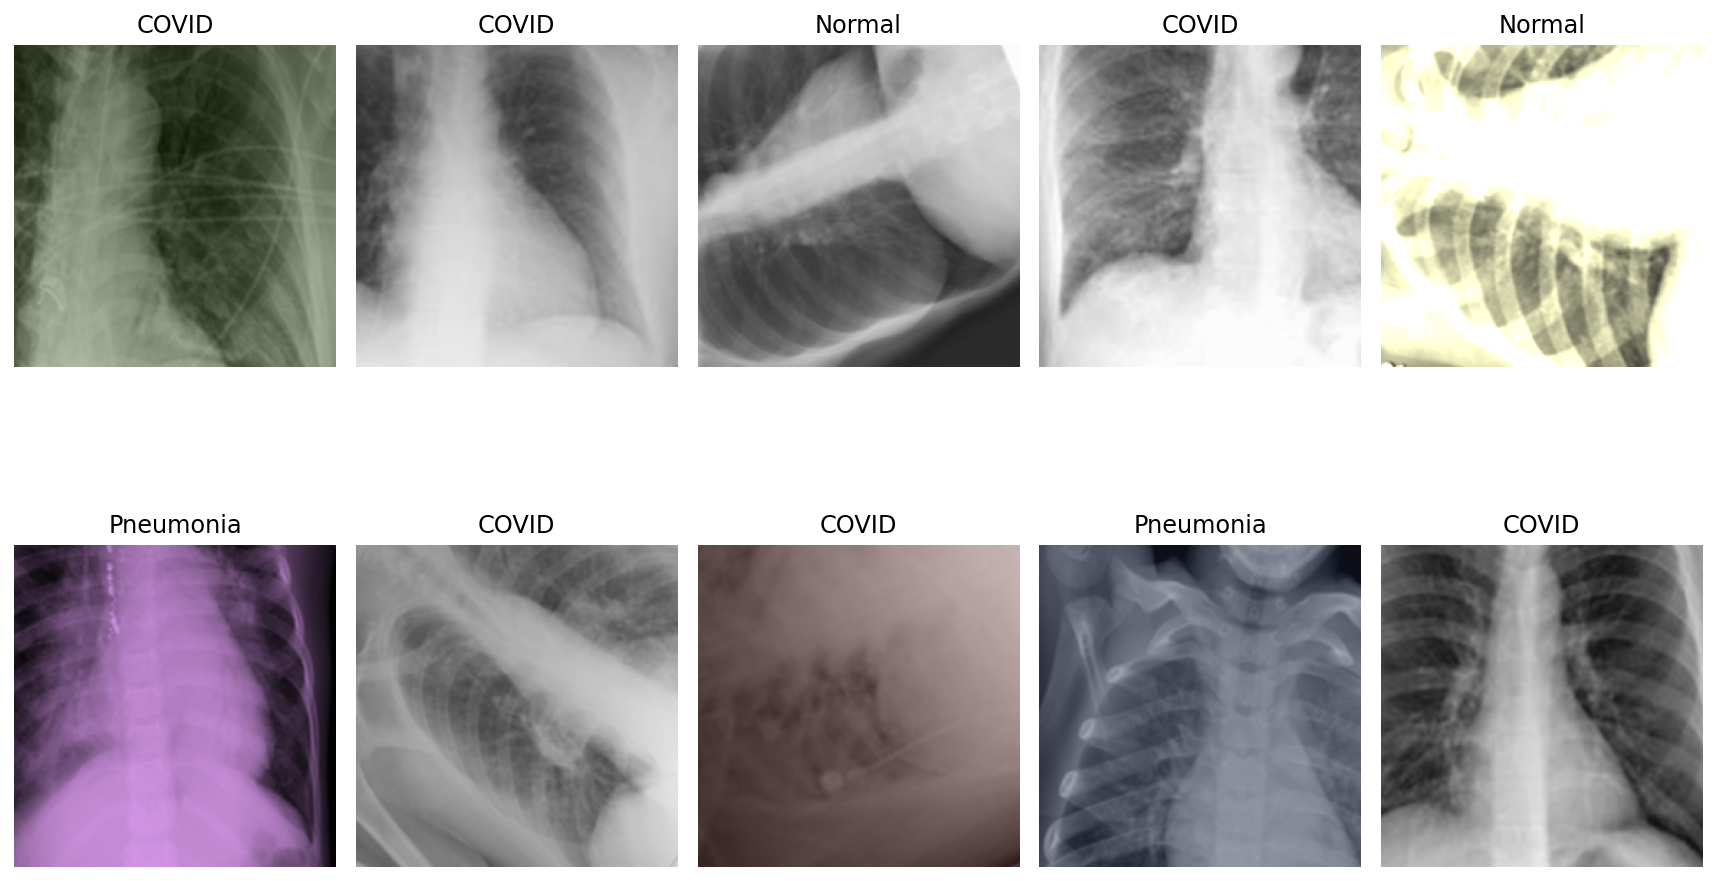

In [15]:
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)

    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [16]:
from torch.utils.data import DataLoader
trainloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)

valloader = DataLoader(
    valid_dataset, batch_size=8, shuffle=True
)


testloader = DataLoader(
    test_dataset, batch_size=8, shuffle=False
)

In [17]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

In [18]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric


In [19]:
metric = load_metric("glue","mrpc", average="none")
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [20]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = ImageClassificationCollator(feature_extractor)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

DEBUG:filelock:Attempting to acquire lock 139917766076688 on /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc.lock
DEBUG:filelock:Lock 139917766076688 acquired on /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc.lock


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139917766076688 on /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc.lock
DEBUG:filelock:Lock 139917766076688 released on /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc.lock
DEBUG:filelock:Attempting to acquire lock 139917766076688 on /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.d319ae673c1dfeefed4e9e154cf674533971813ff9d9a0d5493a88feca5178c8.lock
DEBUG:filelock:Lock 139917766076688 acquired on /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.d319ae673c1dfeefed4e9e154cf674533971813ff9d9a0d5493a88feca5178c8.lock


Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139917766076688 on /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.d319ae673c1dfeefed4e9e154cf674533971813ff9d9a0d5493a88feca5178c8.lock
DEBUG:filelock:Lock 139917766076688 released on /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.d319ae673c1dfeefed4e9e154cf674533971813ff9d9a0d5493a88feca5178c8.lock
DEBUG:filelock:Attempting to acquire lock 139917765831184 on /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e.lock
DEBUG:filelock:Lock 139917765831184 acquired on /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e.lock


Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139917765831184 on /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e.lock
DEBUG:filelock:Lock 139917765831184 released on /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e.lock
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to 

In [21]:
training_args = TrainingArguments(output_dir='/content/drive/MyDrive/outputs', do_train=True, per_device_train_batch_size=16, per_device_eval_batch_size=16, 
                                  learning_rate=1e-3/32, weight_decay=1e-2, adam_epsilon=1e-6, max_grad_norm=1.0, max_steps=600, warmup_steps=60, 
                                  logging_steps=50, save_steps=600, dataloader_num_workers=2, report_to="none", dataloader_drop_last=True,
                                  ignore_data_skip=True,
                                  seed=1, 
                                  tpu_num_cores=8
                                )
trainer = Trainer(model=model, args=training_args, data_collator=collator, train_dataset=train_dataset, compute_metrics=compute_metrics)

max_steps is given, it will override any value given in num_train_epochs


In [22]:
trainer.train()

***** Running training *****
  Num examples = 960
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 600
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss
50,0.644600
100,0.353700
150,0.277600
200,0.213600
250,0.232600
300,0.214300
350,0.207300
400,0.184200
450,0.168000
500,0.165600


Saving model checkpoint to /content/drive/MyDrive/outputs/checkpoint-600
Configuration saved in /content/drive/MyDrive/outputs/checkpoint-600/config.json
Model weights saved in /content/drive/MyDrive/outputs/checkpoint-600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=600, training_loss=0.25140419165293376, metrics={'train_runtime': 539.6422, 'train_samples_per_second': 17.79, 'train_steps_per_second': 1.112, 'total_flos': 0.0, 'train_loss': 0.25140419165293376, 'epoch': 10.0})

In [23]:
predictions = trainer.predict(valid_dataset)
predictions = np.argmax(logits, axis=1)
metric.compute(predictions=predictions, references=predictions.label_ids)

***** Running Prediction *****
  Num examples = 240
  Batch size = 16


ValueError: ignored